In [6]:
from models.base_model import PatchTrADencoder
import yaml 
from types import SimpleNamespace
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [7]:
config_pre = yaml.load(open("conf/encoder/config_encoder.yaml"), Loader=yaml.FullLoader)
config = SimpleNamespace(**config_pre)

In [14]:
encoder = PatchTrADencoder(config)
#checkpoint_path = "checkpoints/ts_jepa_vicreg_v3" + "_" + "1" + ".ckpt"
#checkpoint = torch.load(checkpoint_path, weights_only=True)
#encoder.load_state_dict(checkpoint)

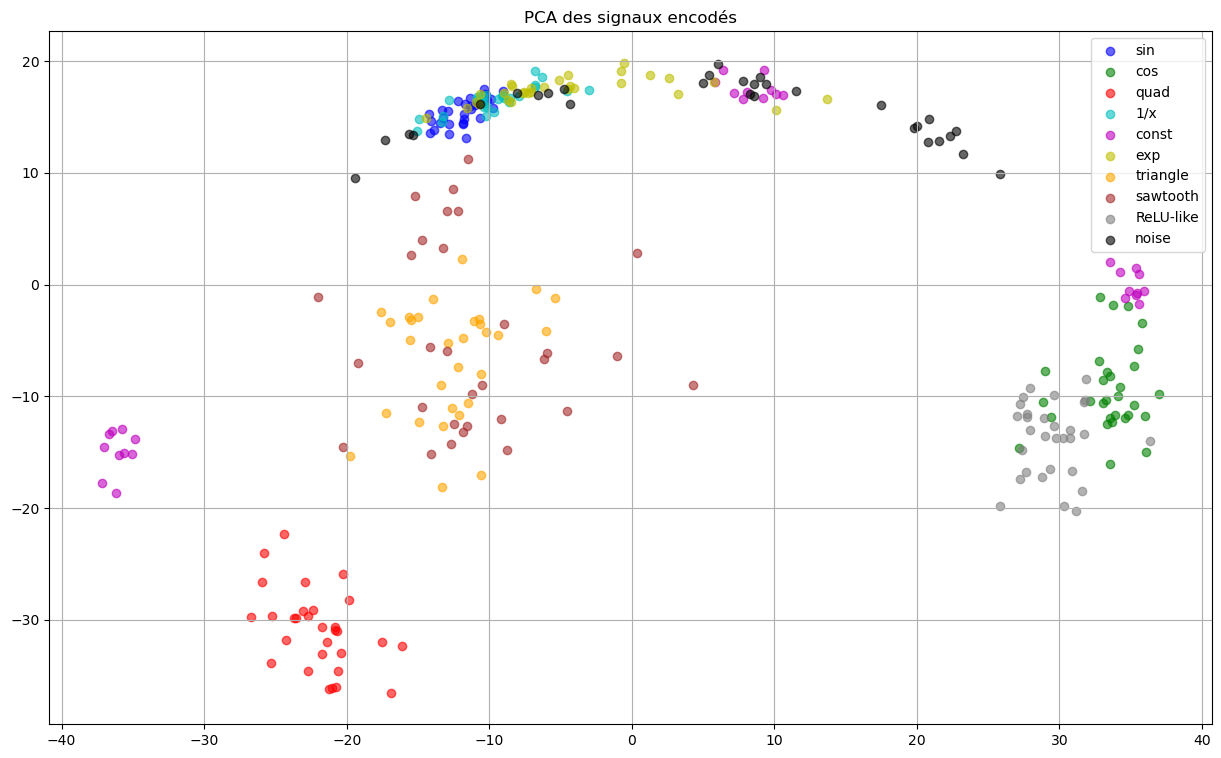

In [15]:
def generate_and_encode_signal(signal_fn, start_vals, encoder):
    ys = []
    for start in start_vals:
        x = torch.linspace(1 * start, 1 * start + 50, 100)
        y = signal_fn(x)
        y = y.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_len, 1]
        with torch.no_grad():
            _, encoded = encoder(y)
        encoded = encoded.squeeze(0).squeeze(-1)
        ys.append(encoded)
    return torch.stack(ys, dim=0)

start_vals = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60]

# Définir les variantes pour chaque type de signal
sin_variants = [
    lambda x: torch.sin(x),
    lambda x: torch.sin(x / 2),
    lambda x: torch.sin(x * 2)
]

cos_variants = [
    lambda x: torch.cos(x / 5) + 10,
    lambda x: torch.cos(x / 3) + 5,
    lambda x: 2 * torch.cos(x / 6) + 7
]

quad_variants = [
    lambda x: -x ** 2,
    lambda x: -(x - 25) ** 2,
    lambda x: -0.5 * x ** 2 + 10
]

inv_variants = [
    lambda x: 1 / (x + 1),               # décale pour éviter div par 0
    lambda x: 2 / (x + 1),
    lambda x: -1 / (x + 1)
]

const_variants = [
    lambda x: torch.ones_like(x) * 3,
    lambda x: torch.ones_like(x) * -2,
    lambda x: torch.ones_like(x) * 0.5
]

exp_variants = [
    lambda x: torch.exp(-x / 10),
    lambda x: torch.exp(-x / 20),
    lambda x: 2 * torch.exp(-x / 15)
]

triangle_variants = [
    lambda x: 2 * torch.abs((x % 10) - 5) - 5,
    lambda x: torch.abs((x % 20) - 10) - 5,
    lambda x: 4 * torch.abs(((x / 2) % 5) - 2.5) - 5
]

sawtooth_variants = [
    lambda x: (x % 10) - 5,
    lambda x: ((x % 20) - 10) / 2,
    lambda x: (x % 5) - 2.5
]

relu_like_variants = [
    lambda x: torch.nn.functional.relu(x - 25),
    lambda x: torch.nn.functional.relu(x - 15) * 0.5,
    lambda x: torch.nn.functional.relu(x - 35) * 2
]

noise_variants = [
    lambda x: torch.rand_like(x),                      # bruit uniforme [0, 1]
    lambda x: torch.randn_like(x),                     # bruit gaussien
    lambda x: torch.randn_like(x) * 0.5 + 1.0          # gaussien centré en 1
]


# Générer les embeddings pour chaque type
sin_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in sin_variants], dim=0)
cos_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in cos_variants], dim=0)
quad_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in quad_variants], dim=0)
inv_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in inv_variants], dim=0)
const_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in const_variants], dim=0)
exp_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in exp_variants], dim=0)
triangle_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in triangle_variants], dim=0)
saw_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in sawtooth_variants], dim=0)
relu_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in relu_like_variants], dim=0)
noise_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in noise_variants], dim=0)

# Empiler et aplatir
all_signals = torch.cat([
    sin_ys, cos_ys, quad_ys, inv_ys, const_ys,
    exp_ys, triangle_ys, saw_ys, relu_ys, noise_ys
], dim=0)

all_signals = all_signals.flatten(start_dim=1)

# PCA
pca = PCA(n_components=2)
all_np = all_signals.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

# Affichage
N = len(start_vals)
plt.figure(figsize=(15, 9))
labels = ["sin", "cos", "quad", "1/x", "const", "exp", "triangle", "sawtooth", "ReLU-like", "noise"]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

for i, label in enumerate(labels):
    plt.scatter(
        embeddings_2d[i*N*3:(i+1)*N*3, 0],
        embeddings_2d[i*N*3:(i+1)*N*3, 1],
        alpha=0.6, label=label, color=colors[i % len(colors)]
    )

plt.legend()
plt.title("PCA des signaux encodés")
plt.grid(True)
plt.show()
